In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math


from mne import (io, compute_raw_covariance, read_events, pick_types, Epochs)
from mne.preprocessing import Xdawn

In [2]:
from common import EEG_fif

In [3]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = ''
base_url = 'https://physionet.org/files/eegmmidb/'
#runs = [4, 6, 8, 10, 12,14]
#runs = [3,5,7,9,11,13]
#runs = [3,4,5,6,7,8,9,10,11,12,13,14]

runs = [3,5,7,9]
#runs = [4,6,8,10]
#runs = [3,5,7,9,4,6,8,10]
subjects = [24]

print(path)
eeg = EEG_fif(path, base_url, subjects, runs)
raw=eeg.data_to_raw()

print("Raw done")
# apply filter
#freq = (1., 45.)

#raw=eeg.raw_ica(n_components=8,max_iter=1000)
raw=raw.notch_filter([50,75,100])
raw=raw.filter( 8,14, method='fir', verbose=20)


print("Filter done")

/home/nutapolt/eeg_mi/common.py:627: RuntimeWarning: This filename (S024/S024R03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/nutapolt/eeg_mi/common.py:627: RuntimeWarning: This filename (S024/S024R05.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/nutapolt/eeg_mi/common.py:627: RuntimeWarning: This filename (S024/S024R07.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fi

Raw done
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 4 contiguous segments
Setting up band-pass filter from 8 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 413 samples (1.652 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filter done


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


In [4]:
raw.ch_names

['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'STIM MARKERS']

In [5]:
raw = raw.drop_channels(['Fp1', 'Fp2', 'P7', 'P8', 'O1', 'O2']
)
raw.ch_names

['C3', 'C4', 'STIM MARKERS']

In [6]:
#epochs=eeg.epochs_visu(raw,tmin=0,tmax=6,baseline=(0,3))
epochs=eeg.epochs_visu(raw,tmin=0,tmax=7,baseline=(0,2))

360 events found
Event IDs: [1 2 4]
Not setting metadata
120 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 120 events and 1751 original time points ...
4 bad epochs dropped


/home/nutapolt/eeg_mi/common.py:657: RuntimeWarning: No matching events found for 3 (event id 3)
  epochs = mne.Epochs(


In [7]:
#epochs.crop(tmin=0,tmax=6)

In [8]:
raw.ch_names

['C3', 'C4', 'STIM MARKERS']

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


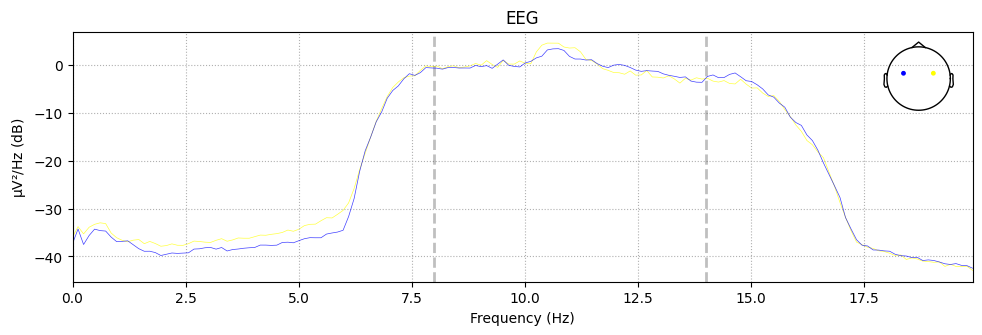

Using matplotlib as 2D backend.


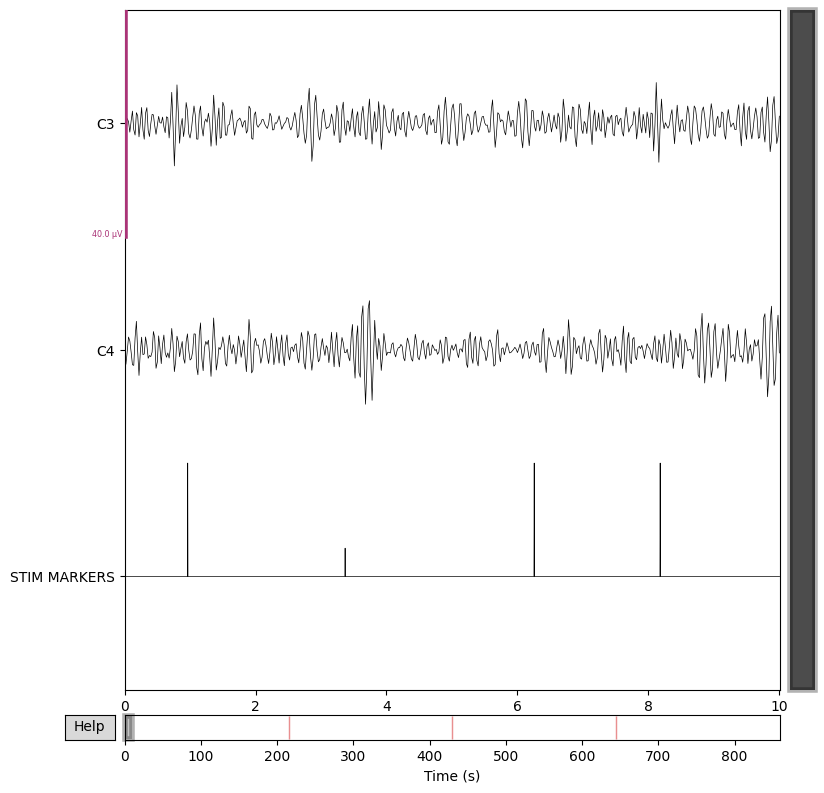

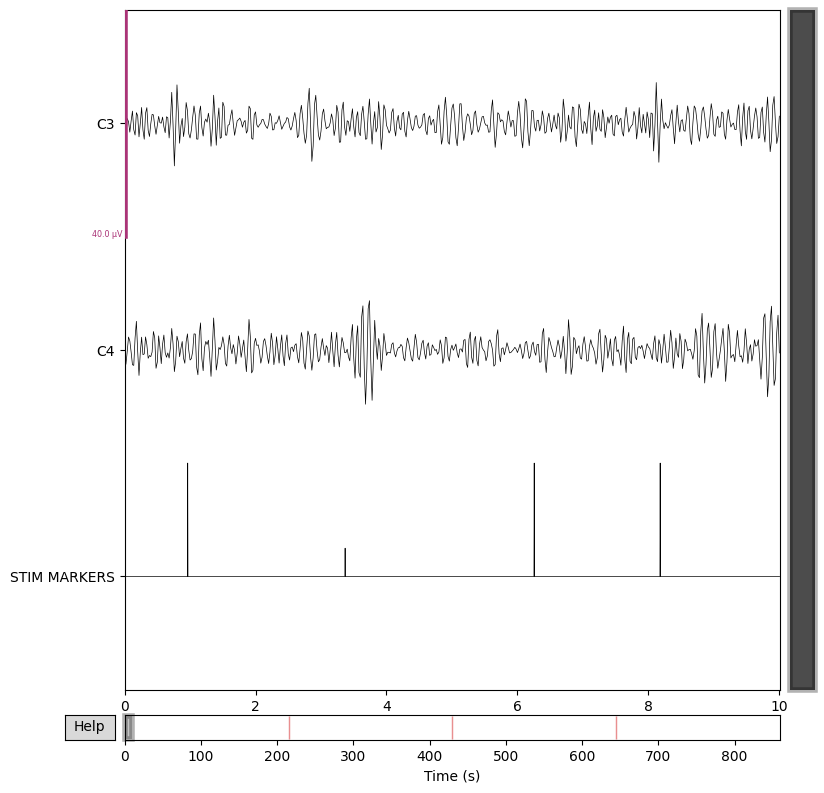

In [9]:
raw.plot_psd(fmax=20)
raw.plot()

In [10]:
epochs

Number of events,116
Events,3: 0Left: 56Right: 60
Time range,0.000 – 7.000 sec
Baseline,0.000 – 2.000 sec


In [11]:
#epochs.event_id = {'Left': 1, 'Right': 2, '3': 3}
#epochs.event_id

In [12]:
l_vis_T1=epochs["Left"].average()
l_vis_T2=epochs["Right"].average()

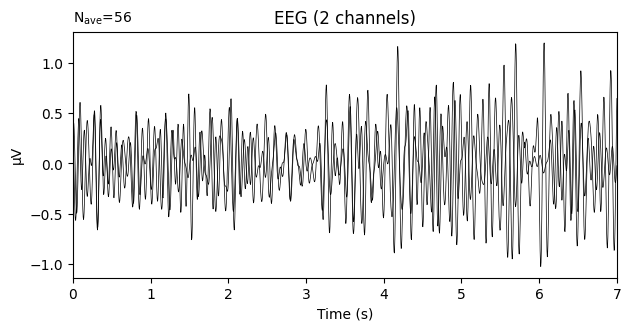

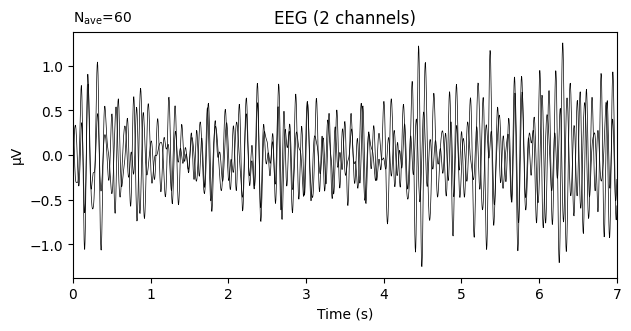

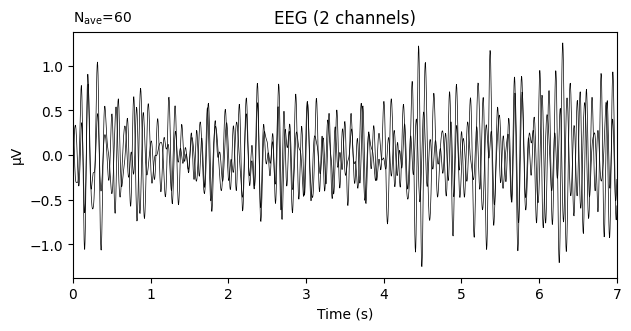

In [13]:
#l_vis_T1.plot(spatial_colors=True)
#l_vis_T2.plot(spatial_colors=True)


l_vis_T1.plot()
l_vis_T2.plot() 

/tmp/ipykernel_499200/3253472254.py:1: RuntimeWarning: More than 25 topomaps plots requested. This might take a while.
  l_vis_T1.plot_topomap(times=list(np.arange(0,7, 0.20)), average=0.05, ch_type="eeg")


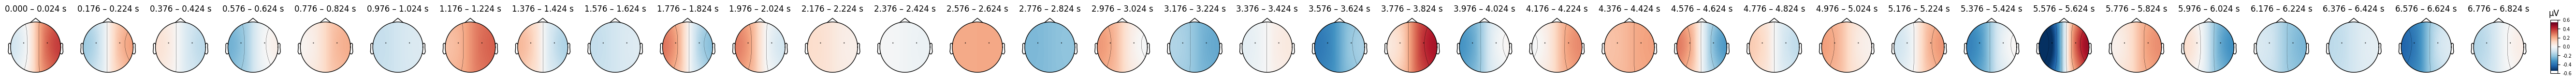

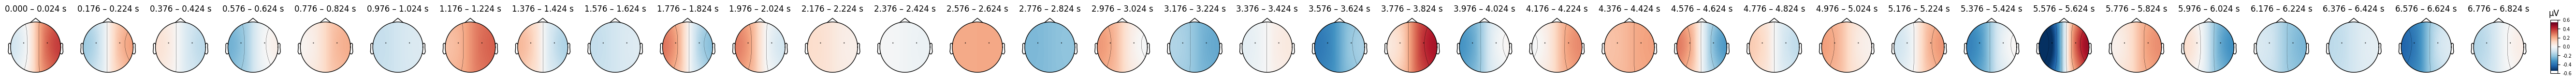

In [14]:
l_vis_T1.plot_topomap(times=list(np.arange(0,7, 0.20)), average=0.05, ch_type="eeg")

/tmp/ipykernel_499200/700911569.py:1: RuntimeWarning: More than 25 topomaps plots requested. This might take a while.
  l_vis_T2.plot_topomap(times=list(np.arange(0, 7, 0.20)), average=0.05, ch_type="eeg")


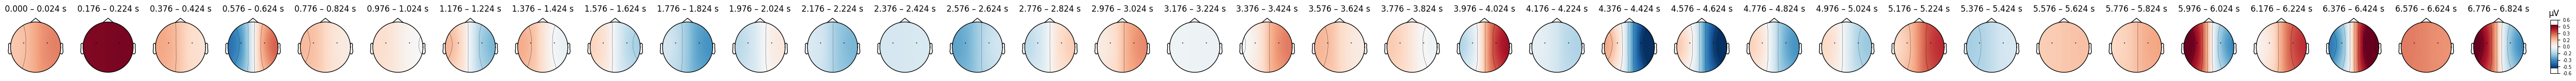

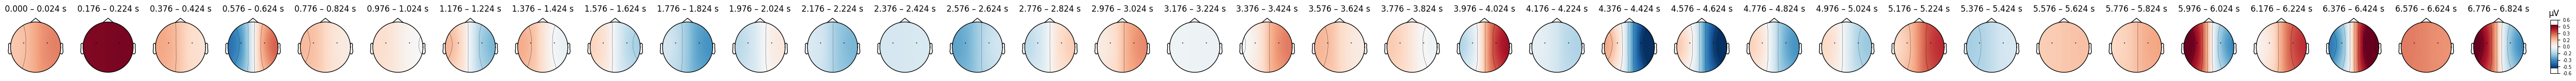

In [15]:
l_vis_T2.plot_topomap(times=list(np.arange(0, 7, 0.20)), average=0.05, ch_type="eeg")

No projector specified for this dataset. Please consider the method self.add_proj.


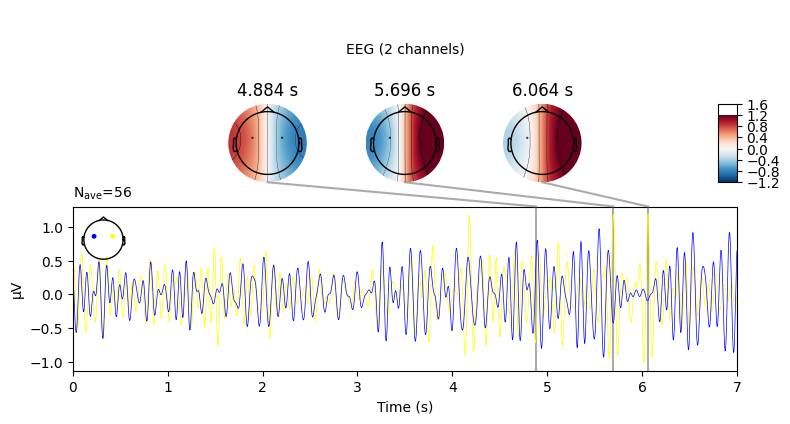

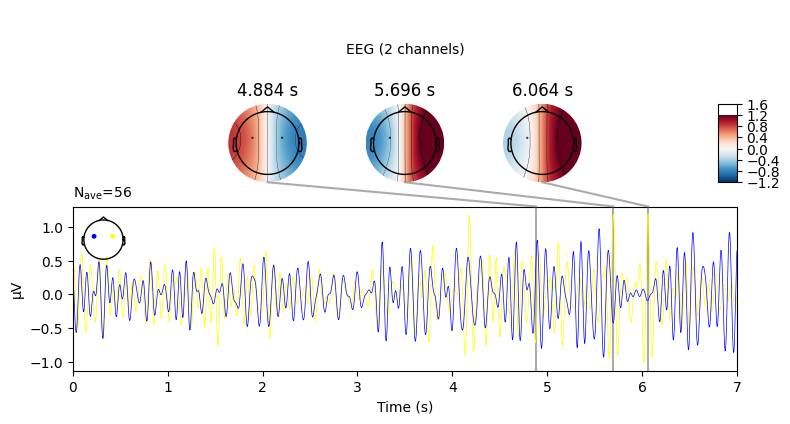

In [16]:
l_vis_T1.plot_joint()



No projector specified for this dataset. Please consider the method self.add_proj.


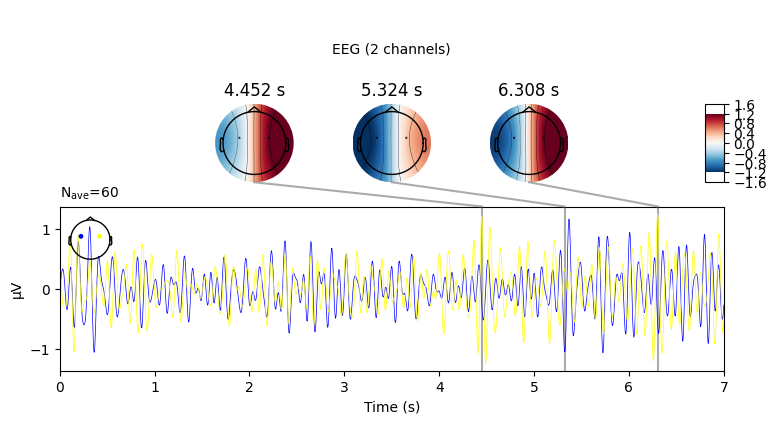

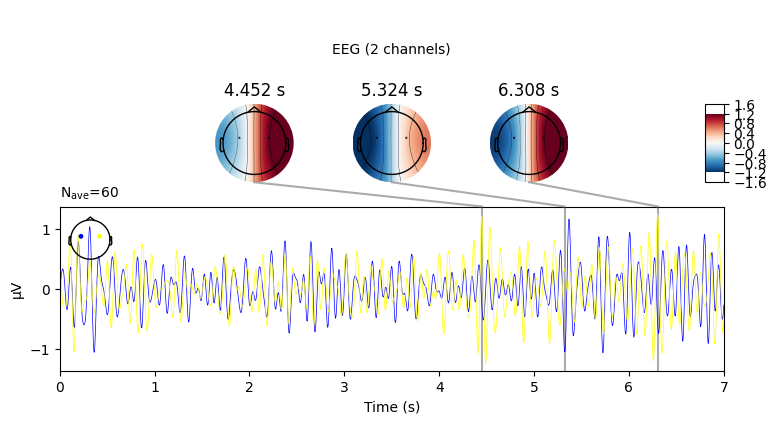

In [17]:
l_vis_T2.plot_joint()



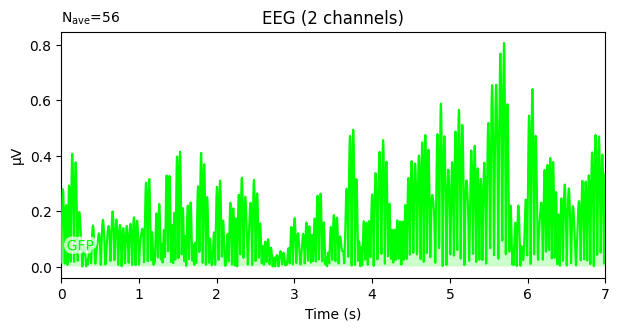

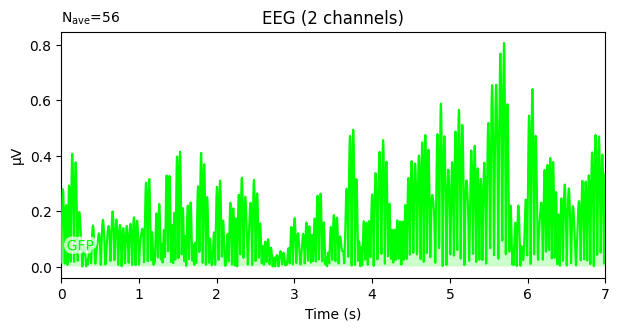

In [18]:
l_vis_T1.plot(gfp='only')

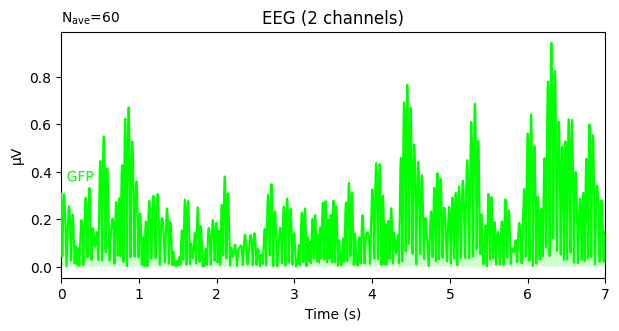

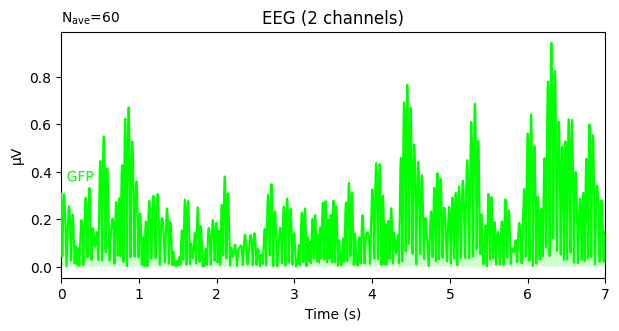

In [19]:
l_vis_T2.plot(gfp='only')

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import seaborn as sns
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test



epochs=eeg.epochs_visu(raw,tmin=0,tmax=7,baseline=(0,2))
#raw=eeg.filter(freq=freq)

360 events found
Event IDs: [1 2 4]
Not setting metadata
120 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 120 events and 1751 original time points ...
4 bad epochs dropped


/home/nutapolt/eeg_mi/common.py:657: RuntimeWarning: No matching events found for 3 (event id 3)
  epochs = mne.Epochs(


In [21]:

freqs = np.arange(8, 14)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (0, 3)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test
tmin, tmax = 0, 8
event_ids = epochs.event_id

In [22]:
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished


In [23]:
df = tfr.to_data_frame(time_format=None)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

df.head()
df = tfr.to_data_frame(time_format=None, long_format=True)
df

Applying baseline correction (mode: percent)


/tmp/ipykernel_499200/15916741.py:2: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.EpochsTFR'>.tmax (7 sec)
  tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")


Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "freq" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


,condition,epoch,freq,time,channel,ch_type,value
0,Right,1,8.0,0.000,C3,eeg,-0.871537
1,Right,1,8.0,0.000,C4,eeg,0.625579
2,Right,1,8.0,0.004,C3,eeg,-0.867556
3,Right,1,8.0,0.004,C4,eeg,0.649294
4,Right,1,8.0,0.008,C3,eeg,-0.861503
...,...,...,...,...,...,...,...
2437387,Right,355,13.0,6.992,C4,eeg,-0.095041
2437388,Right,355,13.0,6.996,C3,eeg,-0.291092
2437389,Right,355,13.0,6.996,C4,eeg,-0.108404
2437390,Right,355,13.0,7.000,C3,eeg,-0.298981


In [24]:
df = tfr.to_data_frame(time_format=None, long_format=True)
df

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "freq" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


,condition,epoch,freq,time,channel,ch_type,value
0,Right,1,8.0,0.000,C3,eeg,-0.871537
1,Right,1,8.0,0.000,C4,eeg,0.625579
2,Right,1,8.0,0.004,C3,eeg,-0.867556
3,Right,1,8.0,0.004,C4,eeg,0.649294
4,Right,1,8.0,0.008,C3,eeg,-0.861503
...,...,...,...,...,...,...,...
2437387,Right,355,13.0,6.992,C4,eeg,-0.095041
2437388,Right,355,13.0,6.996,C3,eeg,-0.291092
2437389,Right,355,13.0,6.996,C4,eeg,-0.108404
2437390,Right,355,13.0,7.000,C3,eeg,-0.298981


In [25]:
# Map to frequency bands:
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 13,
               'beta': 35,
               'gamma': 140}

df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])
df

,condition,epoch,freq,time,channel,ch_type,value,band
0,Right,1,8.0,0.000,C3,eeg,-0.871537,alpha
1,Right,1,8.0,0.000,C4,eeg,0.625579,alpha
2,Right,1,8.0,0.004,C3,eeg,-0.867556,alpha
3,Right,1,8.0,0.004,C4,eeg,0.649294,alpha
4,Right,1,8.0,0.008,C3,eeg,-0.861503,alpha
...,...,...,...,...,...,...,...,...
2437387,Right,355,13.0,6.992,C4,eeg,-0.095041,alpha
2437388,Right,355,13.0,6.996,C3,eeg,-0.291092,alpha
2437389,Right,355,13.0,6.996,C4,eeg,-0.108404,alpha
2437390,Right,355,13.0,7.000,C3,eeg,-0.298981,alpha


In [26]:
# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['delta', 'theta', 'alpha', 'beta']

df = df[df.band.isin(freq_bands_of_interest)]

df['band'] = df['band'].cat.remove_unused_categories()

# Order channels for plotting:
df['channel'] = df['channel'].cat.reorder_categories(('C3', 'C4'),
                                                     ordered=True)
df

,condition,epoch,freq,time,channel,ch_type,value,band
0,Right,1,8.0,0.000,C3,eeg,-0.871537,alpha
1,Right,1,8.0,0.000,C4,eeg,0.625579,alpha
2,Right,1,8.0,0.004,C3,eeg,-0.867556,alpha
3,Right,1,8.0,0.004,C4,eeg,0.649294,alpha
4,Right,1,8.0,0.008,C3,eeg,-0.861503,alpha
...,...,...,...,...,...,...,...,...
2437387,Right,355,13.0,6.992,C4,eeg,-0.095041,alpha
2437388,Right,355,13.0,6.996,C3,eeg,-0.291092,alpha
2437389,Right,355,13.0,6.996,C4,eeg,-0.108404,alpha
2437390,Right,355,13.0,7.000,C3,eeg,-0.298981,alpha


In [27]:

g = sns.FacetGrid(df, row='band', col='condition')
g.map(sns.lineplot, 'time', 'value', 'channel', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(-1, None))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

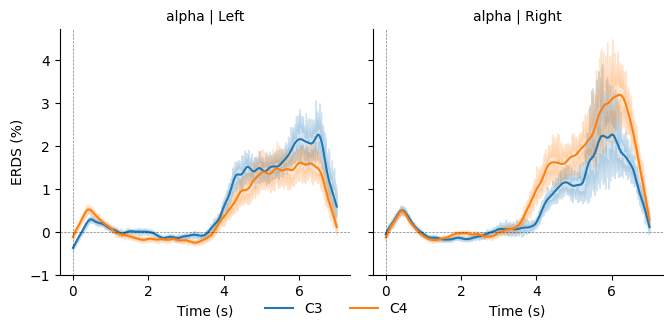

In [28]:
g.fig

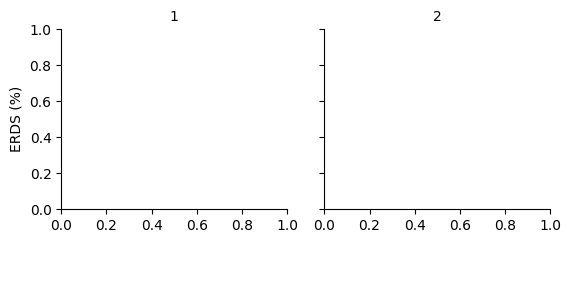

In [29]:
df_mean = (df.query('time > 1')
             .groupby(['condition', 'epoch', 'band', 'channel'])[['value']]
             .mean()
             .reset_index())

g = sns.FacetGrid(df_mean, col='condition', col_order=['1', '2'],
                  margin_titles=True)
g = (g.map(sns.violinplot, 'channel', 'value', 'band', n_boot=10,
           palette='deep', order=['C3',  'C4'],
           hue_order=freq_bands_of_interest,
           linewidth=0.5).add_legend(ncol=4, loc='lower center'))

g.map(plt.axhline, **axline_kw)
g.set_axis_labels("", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)
g.fig

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: percent)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished
/tmp/ipykernel_499200/2943958246.py:3: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.EpochsTFR'>.tmax (7 sec)
  tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")


Using a threshold of 1.673034
stat_fun(H1): min=-8.418750 max=6.195079
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.673034
stat_fun(H1): min=-8.418750 max=6.195079
Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.673034
stat_fun(H1): min=-8.994054 max=6.867478
Running initial clustering …
Found 4 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 1 additional cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #3 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.673034
stat_fun(H1): min=-8.994054 max=6.867478
Running initial clustering …
Found 4 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.673034
stat_fun(H1): min=-8.418750 max=6.195079
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.673034
stat_fun(H1): min=-8.418750 max=6.195079
Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied


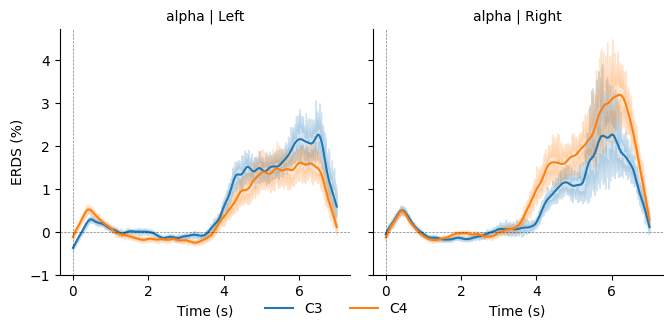

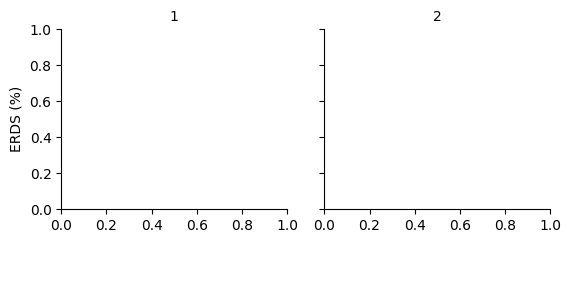

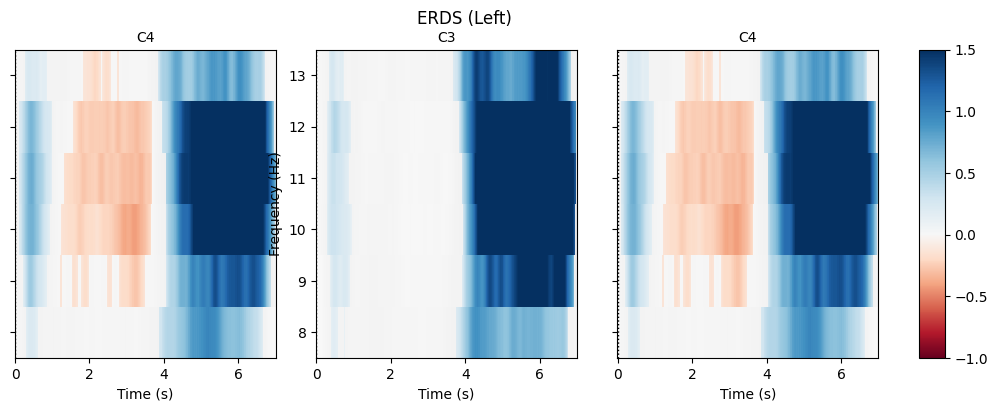

Using a threshold of 1.671093
stat_fun(H1): min=-5.486367 max=6.902564
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.671093
stat_fun(H1): min=-5.486367 max=6.902564
Running initial clustering …
Found 4 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.671093
stat_fun(H1): min=-5.358329 max=6.710577
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.671093
stat_fun(H1): min=-5.358329 max=6.710577
Running initial clustering …
Found 4 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.671093
stat_fun(H1): min=-5.486367 max=6.902564
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.671093
stat_fun(H1): min=-5.486367 max=6.902564
Running initial clustering …
Found 4 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied


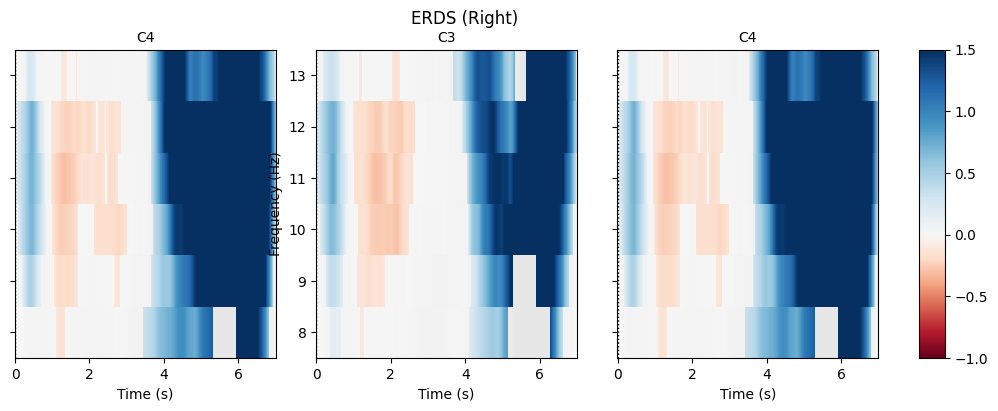

Using a threshold of nan


ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [30]:
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        ch = ch-1
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], cmap="RdBu", cnorm=cnorm, axes=ax,
                              colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()